In [42]:
from sklearn.neural_network import MLPClassifier
import pandas as pd
import numpy as np
import random
from pylab import mpl, plt

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, RMSprop

In [62]:
lags = 5
optimizer = Adam(learning_rate=0.0001)
cutoff = '2020-12-31'

In [33]:
#model = MLPClassifier(hidden_layer_sizes=[32],max_iter=1000, random_state=100)

In [63]:
# Replace 'path/to/your/file.xlsx' with the actual path to your Excel file
file_path = '/Users/benny/Downloads/USD_JPY Historical Data.csv'

# Use pandas to read the Excel file
df = pd.read_csv(file_path)

In [64]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)
df.sort_index(ascending=True,inplace=True)
df.drop(['Open','High','Low','Vol.','Change %'], axis=1, inplace=True)
df['returns'] = np.log(df['Price'] / df['Price'].shift(1))
df['direction'] = np.where(df['returns'] > 0, 1, 0)
df['momentum'] = df['returns'].rolling(5).mean().shift(1)
df['volatility'] = df['returns'].rolling(20).std().shift(1)
df['distance'] = (df['Price'] - df['Price'].rolling(50).mean()).shift(1)

print(df)

             Price   returns  direction  momentum  volatility  distance
Date                                                                   
2010-01-01   93.04       NaN          0       NaN         NaN       NaN
2010-01-04   92.47 -0.006145          0       NaN         NaN       NaN
2010-01-05   91.58 -0.009671          0       NaN         NaN       NaN
2010-01-06   92.38  0.008698          1       NaN         NaN       NaN
2010-01-07   93.45  0.011516          1       NaN         NaN       NaN
...            ...       ...        ...       ...         ...       ...
2024-05-13  156.20  0.003078          1  0.003550    0.007976    3.3294
2024-05-14  156.52  0.002047          1  0.002500    0.007885    3.6956
2024-05-15  154.30 -0.014285          0  0.002249    0.007876    3.8860
2024-05-16  155.41  0.007168          1 -0.001524    0.008537    1.5674
2024-05-17  155.65  0.001543          1 -0.000064    0.008682    2.5298

[3751 rows x 6 columns]


In [65]:
cols = []
for lag in range(1, lags + 1):
              col = f'lag_{lag}'
              df[col] = df['returns'].shift(lag)
              cols.append(col)
df.dropna(inplace=True)

In [66]:
df.round(4).head()

,Price,returns,direction,momentum,volatility,distance,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,,,,,,
2010-03-12,90.57,-0.0012,0,0.0033,0.0064,0.1290,0.0020,0.0055,-0.0034,0.0000,0.0125
2010-03-15,90.33,-0.0027,0,0.0006,0.0064,0.0684,-0.0012,0.0020,0.0055,-0.0034,0.0000
2010-03-16,90.32,-0.0001,0,0.0000,0.0064,-0.1288,-0.0027,-0.0012,0.0020,0.0055,-0.0034
2010-03-17,90.42,0.0011,1,0.0007,0.0064,-0.1136,-0.0001,-0.0027,-0.0012,0.0020,0.0055
2010-03-18,90.49,0.0008,1,-0.0002,0.0061,0.0256,0.0011,-0.0001,-0.0027,-0.0012,0.0020


In [67]:
def set_seeds(seed=100): 
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(100)


In [70]:
set_seeds()
model = Sequential()
model.add(Dense(64, activation='relu',input_shape=(len(cols),)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy'])


/Users/benny/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [71]:
training_data = df[df.index < cutoff].copy()
mu, std = training_data.mean(), training_data.std()
training_data_ = (training_data - mu) / std

In [72]:
test_data = df[df.index >= cutoff].copy()
test_data_ = (test_data - mu) / std

In [73]:
%%time
model.fit(training_data[cols],
        training_data['direction'],
        epochs=50, verbose=False,
        validation_split=0.2, shuffle=False)

CPU times: user 2.74 s, sys: 401 ms, total: 3.14 s
Wall time: 2.49 s


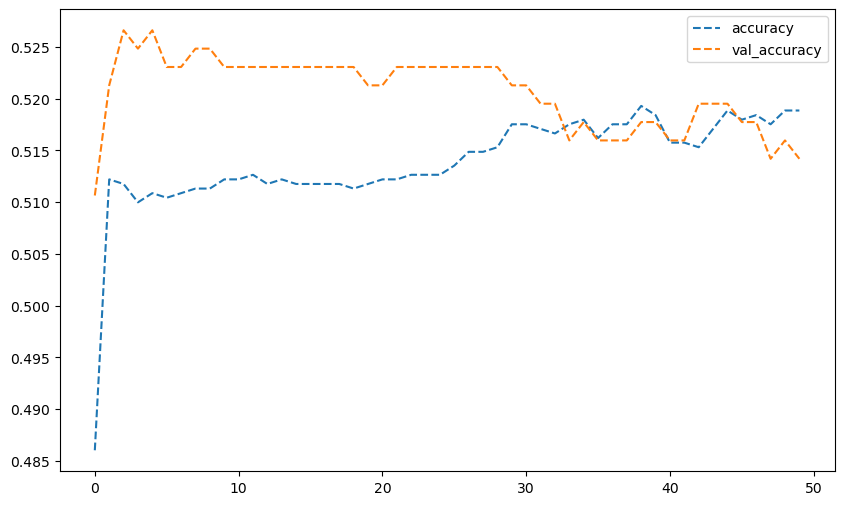

In [74]:
res = pd.DataFrame(model.history.history)
res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');

In [75]:
model.evaluate(training_data_[cols], training_data['direction'])

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step - accuracy: 0.4885 - loss: 1.2997


[1.2549631595611572, 0.4969847500324249]

In [76]:
pred = np.where(model.predict(training_data_[cols]) > 0.5, 1, 0)
training_data['prediction'] = np.where(pred > 0, 1, -1)
training_data['strategy'] = (training_data['prediction'] * training_data['returns'])

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step


In [77]:
training_data[['returns', 'strategy']].sum().apply(np.exp)

returns     1.137737
strategy    1.170983
dtype: float64

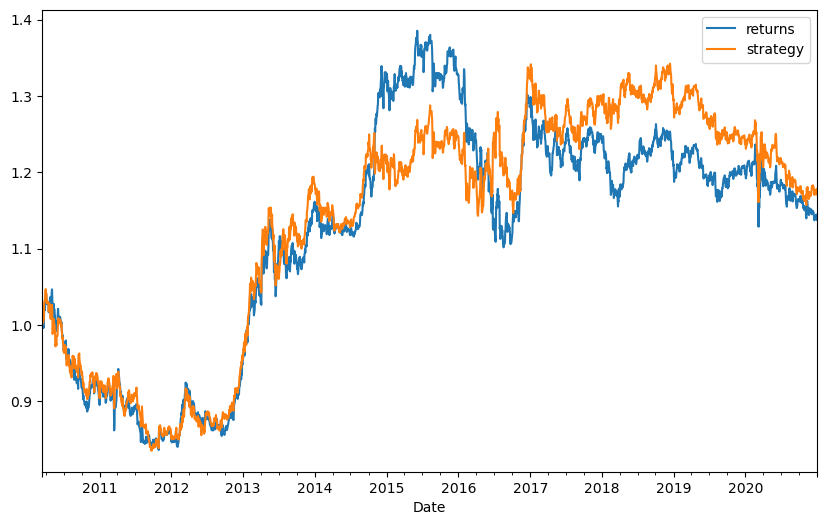

In [78]:
training_data[['returns', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6));

In [79]:
model.evaluate(test_data_[cols], test_data['direction'])

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step - accuracy: 0.5190 - loss: 1.0087


[1.1239861249923706, 0.5464852452278137]

In [80]:
pred = np.where(model.predict(test_data_[cols]) > 0.5, 1, 0)
test_data['prediction'] = np.where(pred > 0, 1, -1)
test_data['strategy'] = (test_data['prediction'] *test_data['returns'])

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step


In [81]:
test_data[['returns', 'strategy']].sum().apply(np.exp)

returns     1.508675
strategy    1.250723
dtype: float64

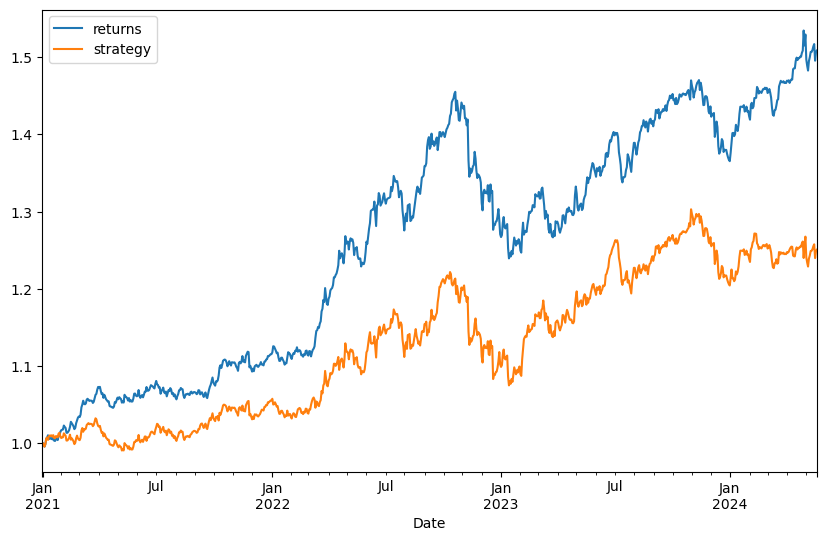

In [82]:
test_data[['returns', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10, 6));